In [54]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

# Load the trajectory and topology
N=7

traj_file = f'N{N}/traj_continuous_v1_400_reduced.xtc'
top_file  = f'N{N}/traj_continuous_v1_400_reduced.pdb' # Å
u = mda.Universe(top_file, traj_file)

ca_atoms = u.select_atoms("protein and name CA")[0:34]
ca_atoms = ca_atoms[np.argsort(ca_atoms.resids)]
print(len(ca_atoms))


34


34


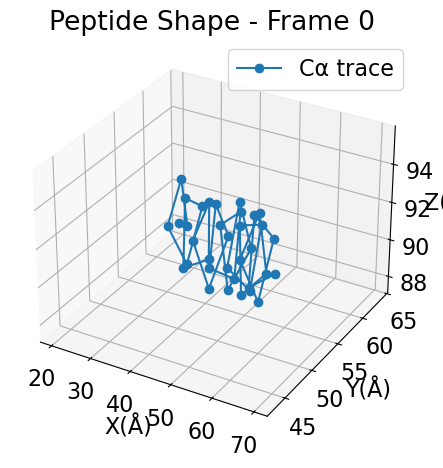

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

positions = ca_atoms.positions
print(len(positions))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], 'o-', label='Cα trace')
ax.set_title("Peptide Shape - Frame 0")
ax.set_xlabel("X(Å)")
ax.set_ylabel("Y(Å)")
ax.set_zlabel("Z(Å)")
ax.legend()
plt.tight_layout()
plt.show()

In [56]:
u.trajectory[0] # Go to the first frame
start_pos = ca_atoms.positions[0]
end_pos = ca_atoms.positions[-1]
end_to_end_distance = np.linalg.norm(end_pos - start_pos)   # Calculate the Euclidean distance (in Å)
print(f"End-to-end distance (frame 0): {end_to_end_distance:.2f} Å")

positions = ca_atoms.positions  # Compute arc length as sum of distances between consecutive Cα atoms
arc_length = sum(np.linalg.norm(positions[i+1] - positions[i]) for i in range(len(positions)-1))
print(f"Arc length (frame 0): {arc_length:.2f} Å")

End-to-end distance (frame 0): 52.35 Å
Arc length (frame 0): 126.64 Å


In [57]:

# Best-Plane fit method
# === Circle fitting helper functions ===
def calc_R(xc, yc, x, y):
    return np.sqrt((x - xc)**2 + (y - yc)**2)

def cost(params, x, y):
    Ri = calc_R(*params, x, y)
    #Ri = np.sqrt((x - params[0])**2 + (y - params[1])**2)
    return Ri - Ri.mean()

def fit_circle_2d(xy_points):
    x, y = xy_points[:, 0], xy_points[:, 1]
    x_m, y_m = x.mean(), y.mean()
    params_init = (x_m, y_m)
    result, _ = leastsq(cost, params_init, args=(x, y))
    xc, yc = result
    radius = calc_R(xc, yc, x, y).mean()
    return radius




Frame 0 radius: 103.50 Å, curvature: 0.0097 Å⁻¹


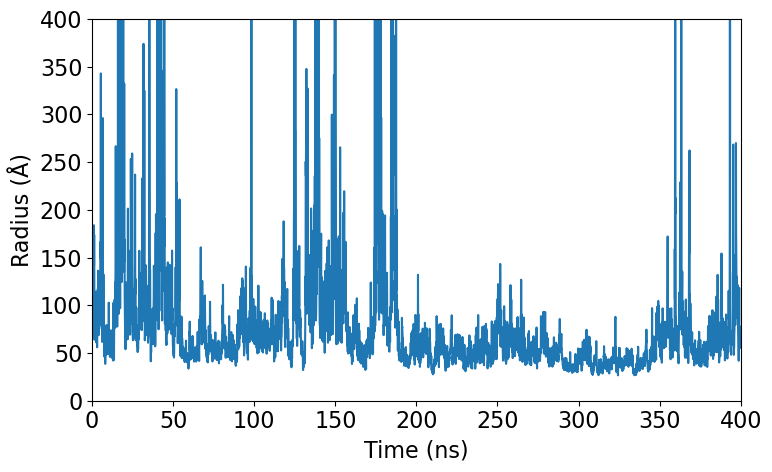

In [58]:

# === Compute radius per frame ===
times = []
curvatures = []
radii = []

window = 11  # smoothing window size for helix backbone axis

for ts in u.trajectory:
    raw_coords = ca_atoms.positions  # (34, 3)

    # === Smooth backbone using sliding window average ===
    coords = np.array([
        raw_coords[i:i + window].mean(axis=0)
        for i in range(len(raw_coords) - window + 1)
    ])

    centroid = coords.mean(axis=0)
    coords_centered = coords - centroid

    # === Fit best-fit plane via SVD ===
    _, _, vh = np.linalg.svd(coords_centered)
    plane_x = vh[0, :]
    plane_y = vh[1, :]

    # === Project into 2D plane ===
    x_proj = coords_centered @ plane_x
    y_proj = coords_centered @ plane_y
    points_2d = np.vstack((x_proj, y_proj)).T

    # === Fit circle to 2D arc ===
    radius = fit_circle_2d(points_2d)
    curvature = 1 / radius if radius != 0 else 0

    times.append(ts.time / 1000)  # ns
    curvatures.append(curvature)
    radii.append(radius)

    # Optional debug print for frame 0
    if ts.frame == 0:
        print(f"Frame 0 radius: {radius:.2f} Å, curvature: {curvature:.4f} Å⁻¹")

# === Plot radius over time with inset ===
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(times, radii, label="Radius")
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Radius (Å)")
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
""""
# Inset zoom (adjust Y range as needed)
axins = inset_axes(ax, width="40%", height="40%", loc="upper right",
                   bbox_to_anchor=(-0.05, -0.05, 1, 1),
                   bbox_transform=ax.transAxes)
axins.plot(times, radii)
axins.set_ylim(10, 300)  # adjust zoom range as needed
axins.set_xlim(times[0], times[-1])
axins.tick_params(labelsize=10)
axins.set_title("Zoomed Radius", fontsize=12)
"""
plt.tight_layout()
plt.savefig(f'N{N}_curved_backbone_radius.png', dpi=300)
plt.show()

